In this analysis, we will explore a dataset of google job ads. Those ads correspond either to the search string `machine learning engineer` or `data scientist`.

In [1]:
import os
import io
import re
import yaml
import warnings

import pandas as pd
import numpy as np

from stemming import porter2

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import cross_validate, GridSearchCV, learning_curve
from sklearn.compose import ColumnTransformer
from sklearn import set_config


import matplotlib as mlib
import matplotlib.pyplot as plt
import seaborn as sns

from google.cloud import storage

In [2]:
warnings.filterwarnings('ignore')

In [3]:
set_config(display='diagram')

In [4]:
config_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'config.yaml'))
with open(config_path, 'r') as config_file:
    config = yaml.load(config_file, Loader=yaml.SafeLoader)

In [5]:
%matplotlib inline

In [6]:
plt.style.use('fivethirtyeight')
plt.rcParams['figure.dpi'] = 180
plt.rcParams['figure.figsize'] = (10, 8)

In [7]:
client = storage.Client(config['project'])
bucket = client.get_bucket(config['bucket'])
blob = bucket.blob(config['dest_file'])
file_content = io.BytesIO(blob.download_as_string())

ads = pd.read_csv(file_content)

In [8]:
ads.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 635 entries, 0 to 634
Data columns (total 7 columns):
id                  635 non-null object
job_descr           629 non-null object
location            552 non-null object
minimum_qual        629 non-null object
preferred_qual      629 non-null object
responsibilities    629 non-null object
title               635 non-null object
dtypes: object(7)
memory usage: 34.9+ KB


First, let us try using simple string operations to derive the additional information from the job title. Such information could be: seniority, function, etc.

In [9]:
ads.fillna('unknown', inplace=True)

In [10]:
def split_title(df):
    df[['role', 'department', 'area', 'other']] = df.title.str.split(',', expand=True)
    return df


def get_seniority(df):
    seniority_re = r'.*(intern|senior|lead|staff|principal|manager|head).*'
    seniority_normal = 'l3-l4'
    seniority_mapping = {'intern': 1,
                         seniority_normal: 3,
                         'senior': 5,
                         'lead': 6,
                         'staff': 7,
                         'principal': 8,
                         'manager': 9,
                         'head': 10}
    
    df['seniority'] = df.role.str.extract(pat=seniority_re, flags=re.I).fillna(seniority_normal)[0].str.lower()
    df['seniority_rank'] = df.seniority.map(seniority_mapping)
    return df


def get_function(df):
    function_re = r'.*(engineer|scientist|science|consultant|architect|advocate|developer|analyst|specialist).*'
    df['function'] = (df.role.str.extract(pat=function_re, flags=re.I)[0]
                      .str.lower().str.replace('science', 'scientist', flags=re.I))
    return df


def print_scores(model, X, y, **kwargs):
    
    cv = kwargs.get('cv', 3)
    
    print(f'Running {cv} cross validation folds...')
    scores = cross_validate(model, X, y, cv=cv, scoring='f1_weighted', return_train_score=True)
    
    print('-'*120)
    for k in scores.keys():
        print(f'{k}, mean: {scores[k].mean():.2f}, std: {scores[k].std():.2f}')


def plot_learning_curves(lc_res):
    fig=plt.figure(figsize=(12, 8))

    legend_handles = []
    
    for i, c, l in zip([1, 2], ['b', 'g'], ['train', 'valid']):
        scores = lc_res[i]
        mean = np.mean(scores, axis=1)
        std = np.std(scores, axis=1)
        
        plt.fill_between(range(0, steps), mean-std, mean+std, color=c, alpha=0.1)
        plt.plot(mean, c=c, linewidth=3, alpha=0.4)
        legend_handles.append(mlib.lines.Line2D([], [], color=c, label=l))
        
        for j in range(3):
            plt.plot(scores[:, j], c=c, linewidth=0.5, alpha=0.4)
    
    plt.ylim(0, 1.01)
    plt.legend(handles=legend_handles)
    plt.ylabel('weighted f1 score')
    plt.xlabel('percentage of training examples')
    plt.title('Learning Curves', pad=30)
    plt.show()


def get_feature_importances(model):
    col_prefix = re.compile('(' + '|'.join([f'tfidf_{c}' for c in text_cols]) + ')(__)(.*)')

    importances_mcp = pd.DataFrame(model['naive_bayes_clf'].feature_log_prob_.transpose(),
                                   columns=label_enc.classes_,
                                   index=model['prep'].get_feature_names())
    
    imp_terms = pd.DataFrame()

    for l in label_enc.classes_:
        imp_scaled = (pd.Series(MinMaxScaler()
                                .fit_transform(importances_mcp[l].values.reshape(-1, 1))[:,0],
                                index=importances_mcp[l].index))
        imp_label = imp_scaled.sort_values(ascending=False)
        to_append = [{'feature': col_prefix.match(feature_term)[1],
                      'term': col_prefix.match(feature_term)[3],
                      'importance': imp,
                      'label': l}
                     for feature_term, imp in zip(imp_label.index, imp_label.values)]
        imp_terms = imp_terms.append(to_append, ignore_index=True)
    
    return imp_terms

In [11]:
ads = split_title(ads)
ads = get_seniority(ads)
ads = get_function(ads)

In [12]:
ads[['title', 'role', 'department', 'area', 'seniority', 'seniority_rank', 'function']].head()

,title,role,department,area,seniority,seniority_rank,function
0,"Cloud AI Engineer, Professional Services",Cloud AI Engineer,Professional Services,None,l3-l4,3,engineer
1,"Cloud AI Engineer, Professional Services",Cloud AI Engineer,Professional Services,None,l3-l4,3,engineer
2,"Conversational AI Engineer, Google Cloud Profe...",Conversational AI Engineer,Google Cloud Professional Services,None,l3-l4,3,engineer
3,"Cloud AI Engineer, Professional Services",Cloud AI Engineer,Professional Services,None,l3-l4,3,engineer
4,"Data Scientist, Engineering",Data Scientist,Engineering,None,l3-l4,3,scientist


An interesting insight could be to see the most relevant terms from the qualifications and responsibilities with regards to the function. This could give us an isight into the keywords that one should emphasize on in their resume.

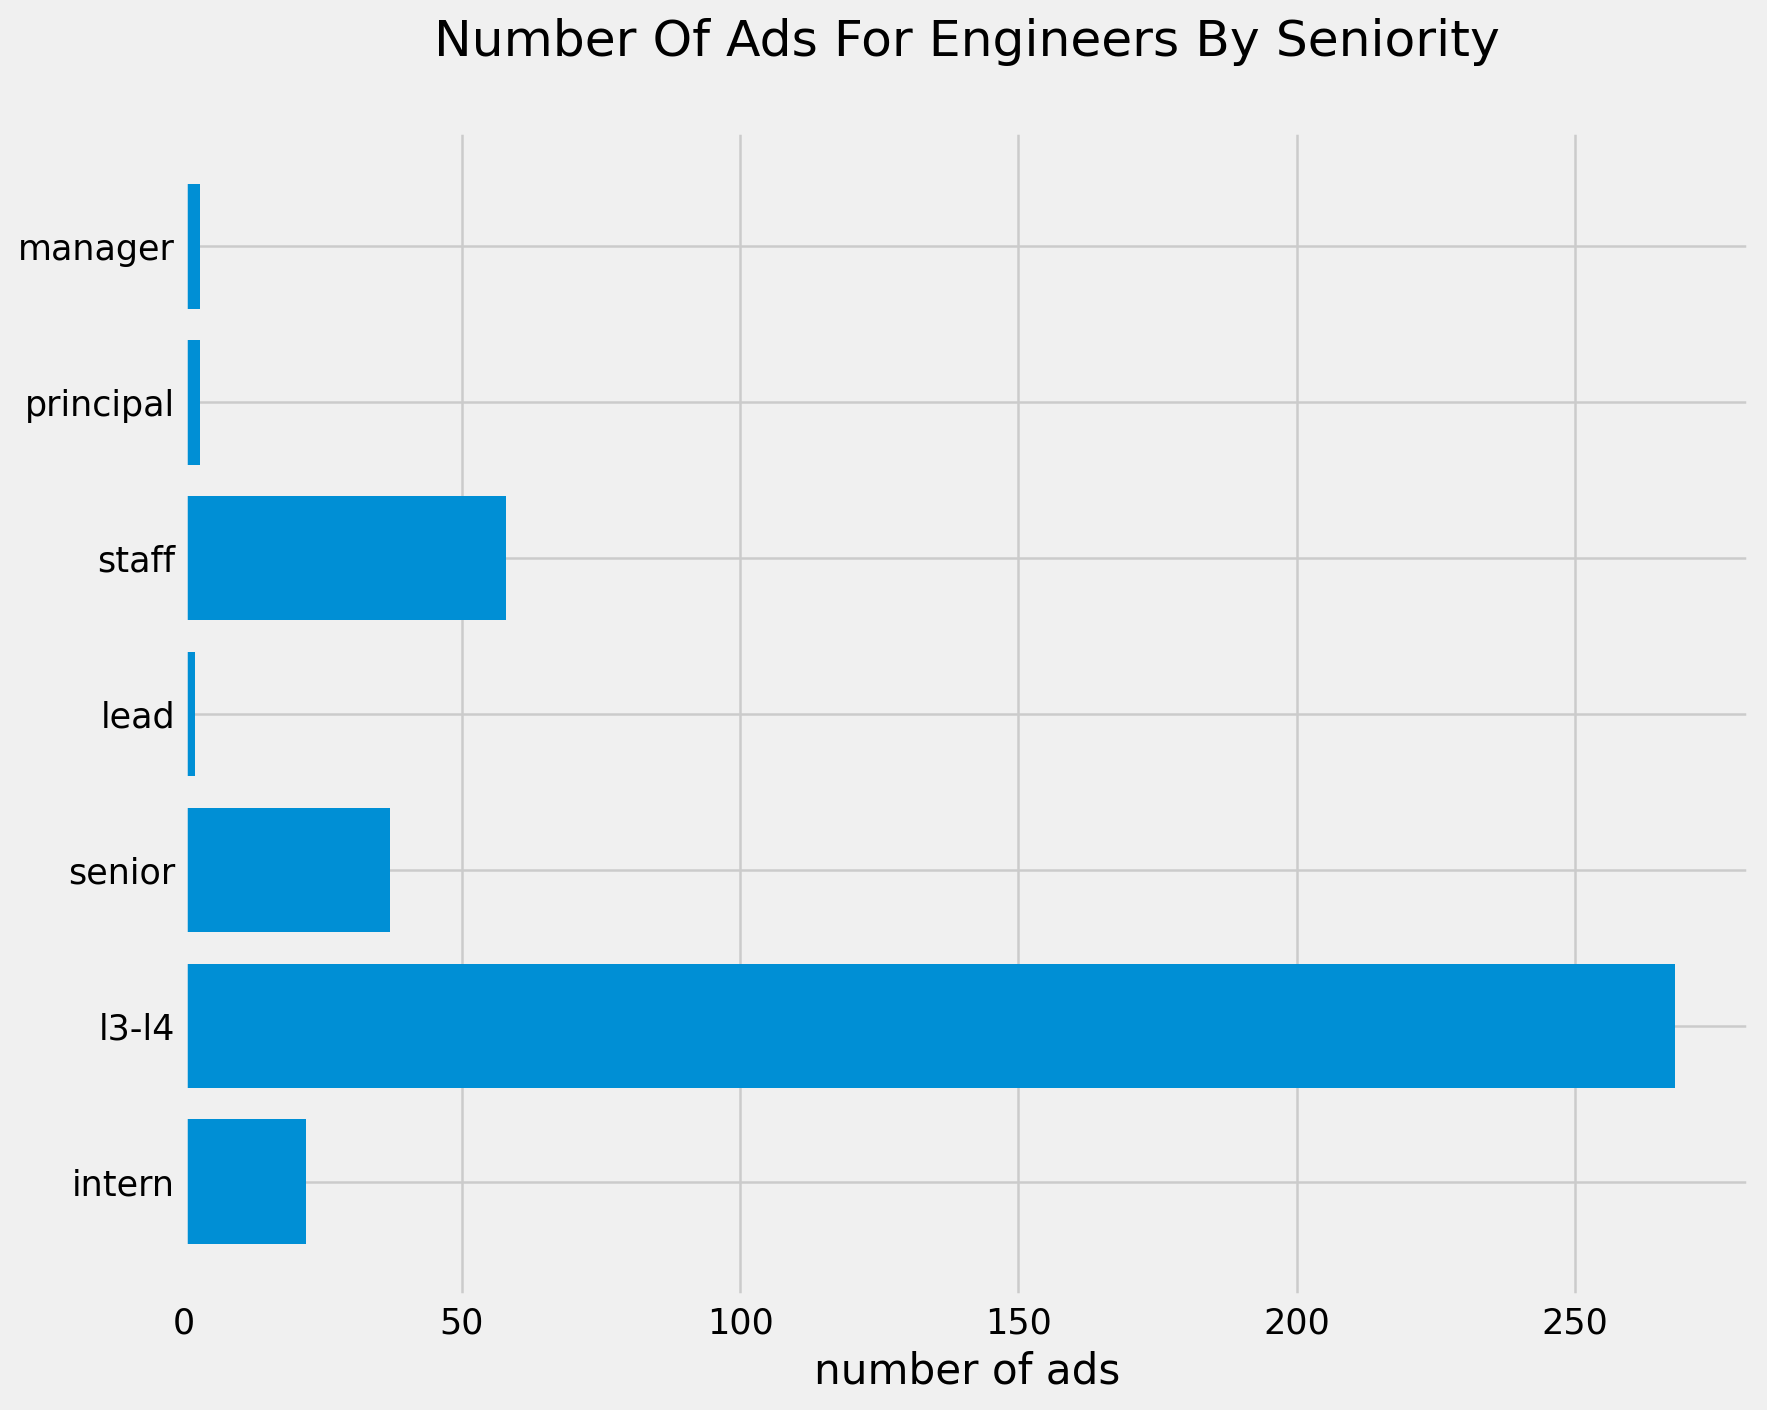

In [13]:
to_plot = (ads[ads.function=='engineer']
           .groupby(['seniority', 'seniority_rank'])
           .id.nunique().sort_index(level=1))

plt.barh(to_plot.index.get_level_values('seniority'), to_plot.values)
plt.xlabel('number of ads')
plt.title('Number Of Ads For Engineers By Seniority', pad=30)
plt.show()

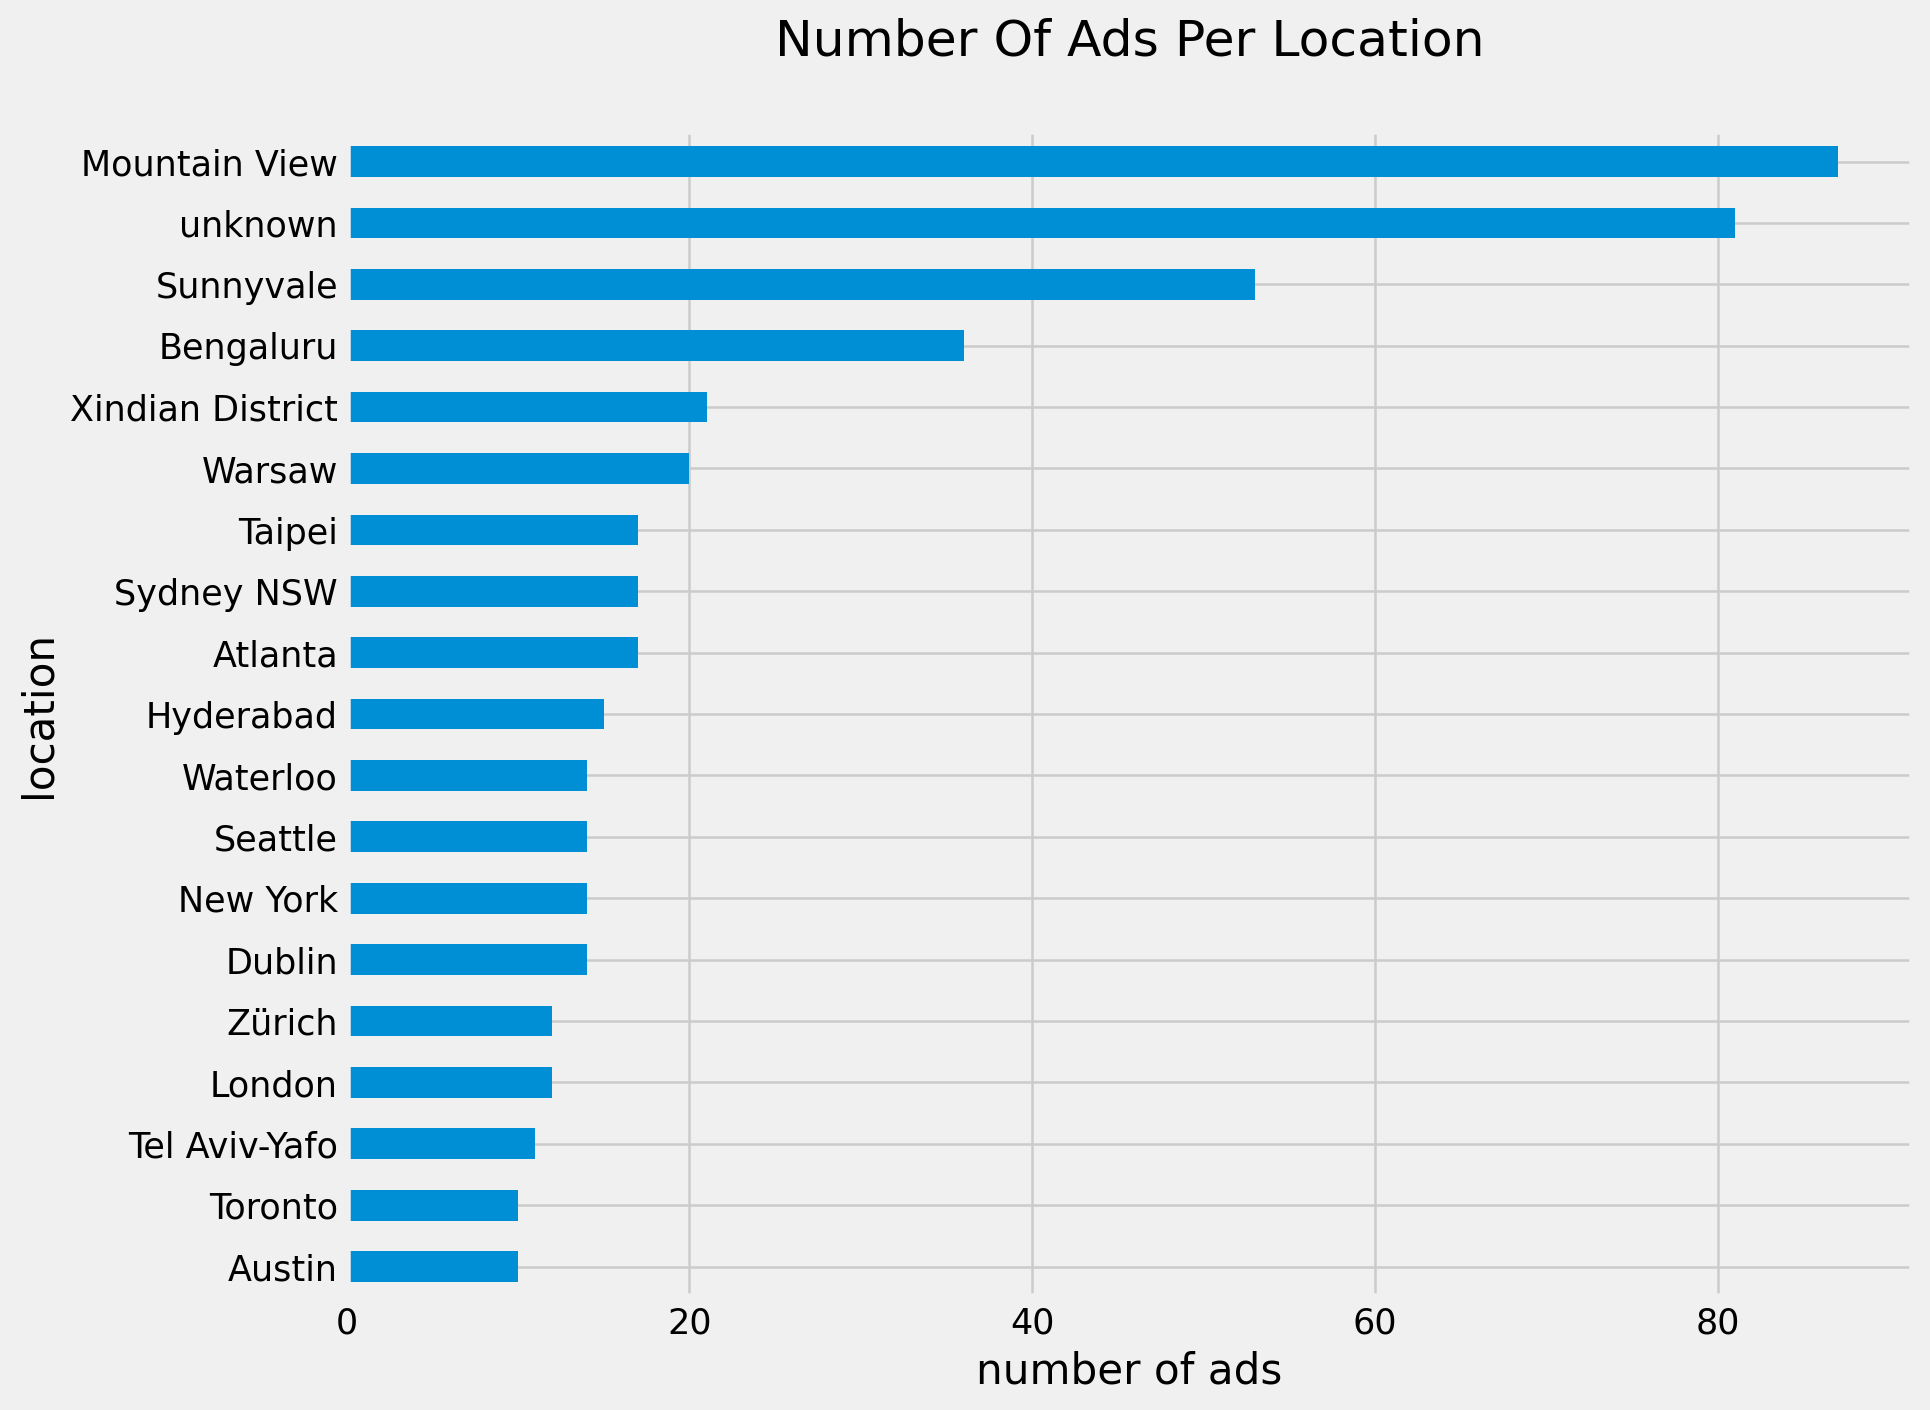

In [14]:
to_plot = ads.groupby('location').id.nunique()
to_plot[to_plot>=10].sort_values().plot.barh()
plt.xlabel('number of ads')
plt.title('Number Of Ads Per Location', pad=30)
plt.show()

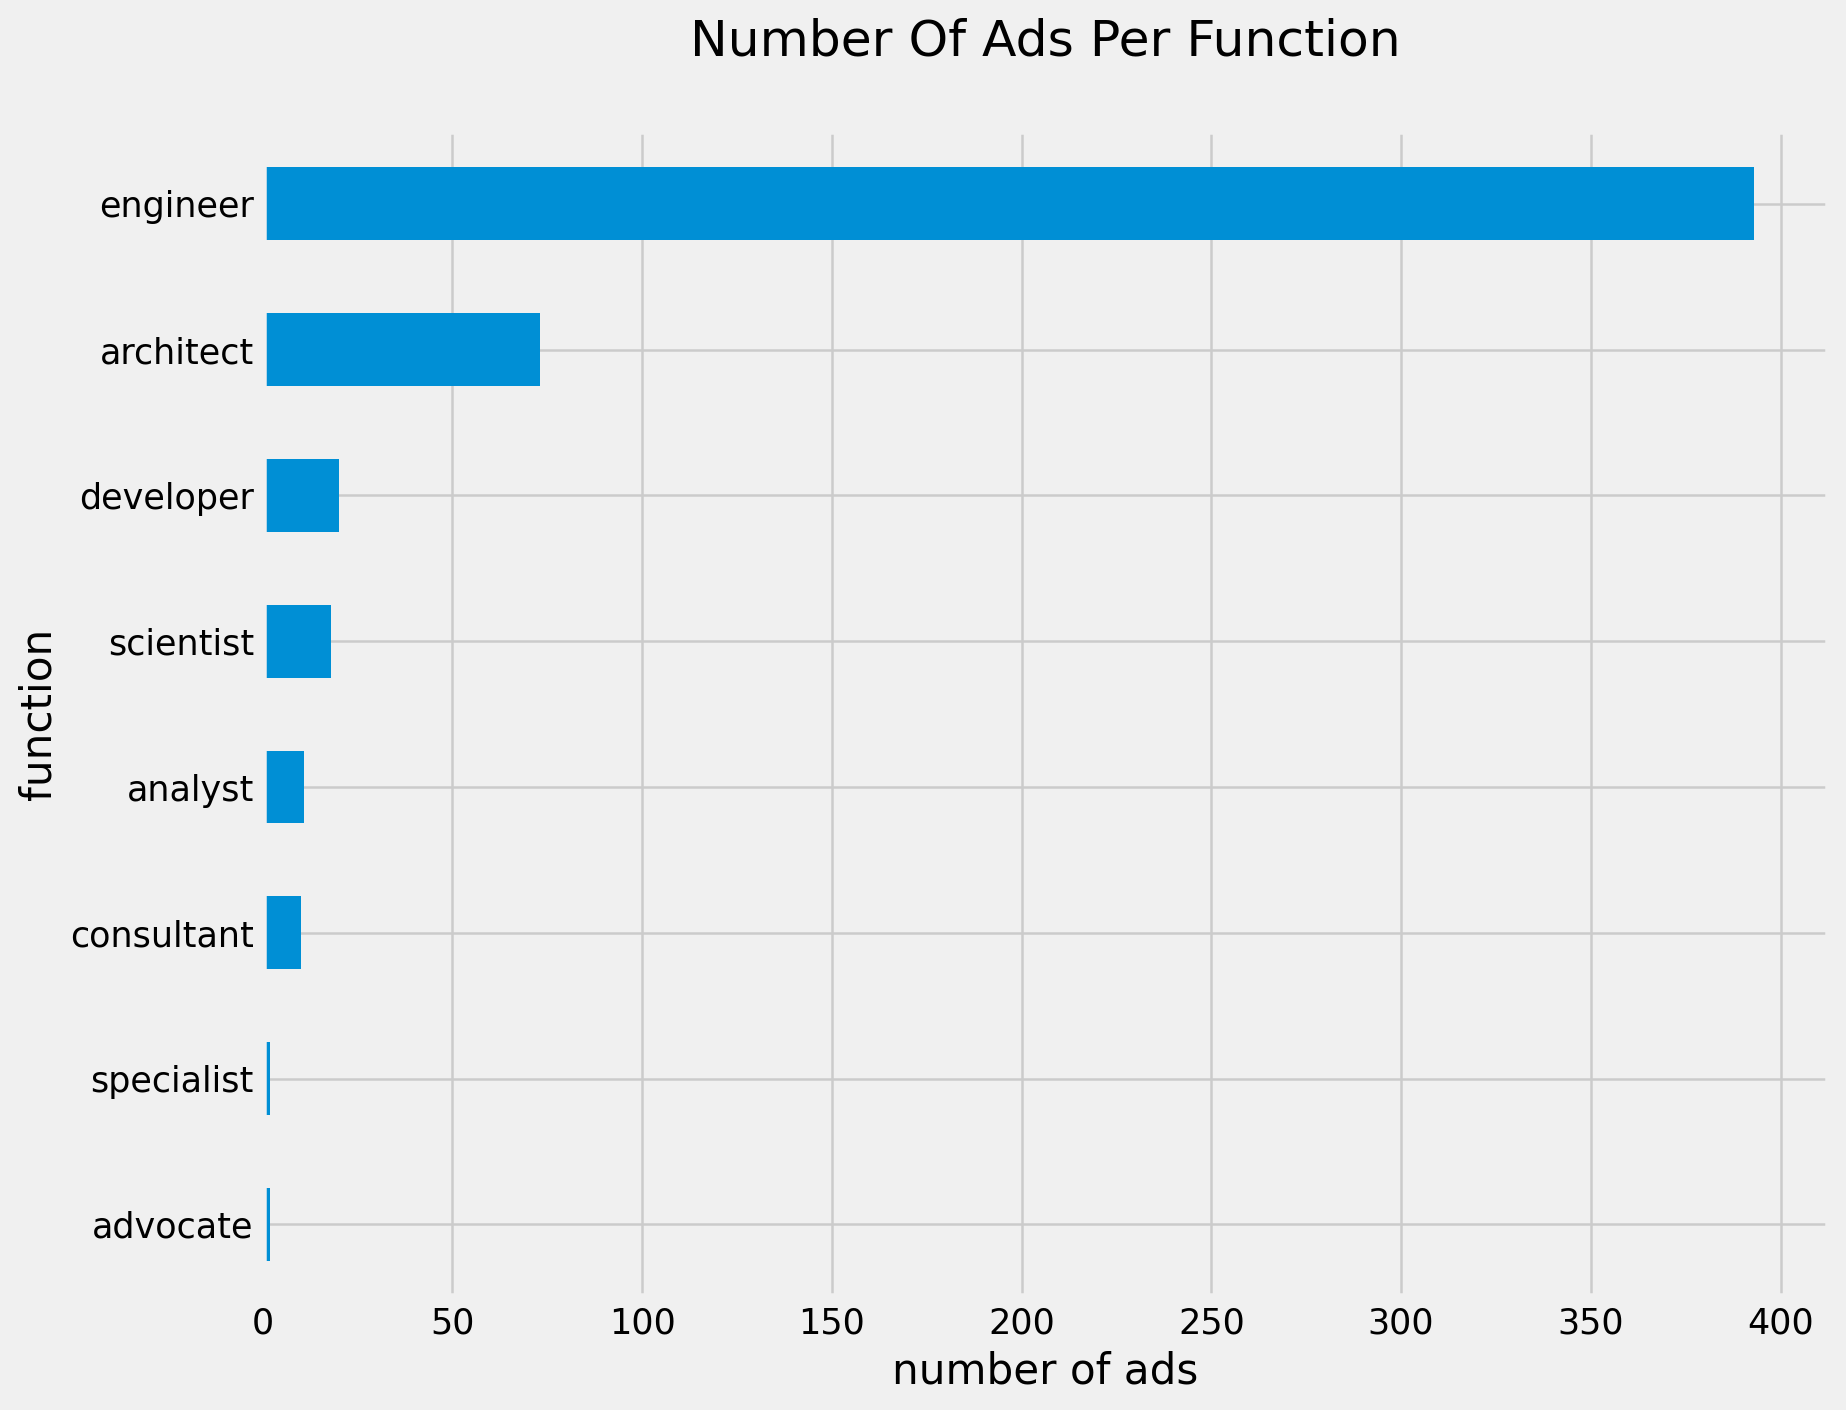

In [15]:
to_plot = ads.groupby('function').id.nunique()
to_plot.sort_values().plot.barh()
plt.xlabel('number of ads')
plt.title('Number Of Ads Per Function', pad=30)
plt.show()

In [16]:
location_counts = ads.location.value_counts()
functions_counts = ads.function.value_counts()
seniority_counts = ads.seniority.value_counts()

## Model On Function

In [17]:
min_n_ads_function = 20

conditions = (
    (ads.function.isin(functions_counts[functions_counts>=min_n_ads_function].index.to_list()))
    # & (ads.location.isin(location_counts[location_counts>=3].index.to_list()))
)

to_model = ads[conditions].copy()

In [18]:
label_enc = LabelEncoder()
to_model['function_enc'] = label_enc.fit_transform(to_model.function.astype('str'))

In [19]:
tfidf_params = {'stop_words': 'english',
                'ngram_range': (2, 5),
                'strip_accents': 'unicode'}

text_cols = ['job_descr', 'minimum_qual', 'preferred_qual', 'responsibilities']

prep_steps = []
prep_steps.extend([(f'tfidf_{c}', TfidfVectorizer(**tfidf_params), c) for c in text_cols])
# prep_steps.append(('loc_enc', OneHotEncoder(handle_unknown='ignore'), ['location']))

preprocess = ColumnTransformer(prep_steps)

multi_col_pipe = Pipeline([
    ('prep', preprocess),
    ('naive_bayes_clf', MultinomialNB())
])

In [20]:
X = to_model.drop('function_enc', axis=1)
y = to_model.function_enc

In [21]:
model = multi_col_pipe.fit(X, y)

In [22]:
model

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('tfidf_job_descr',
                                                  TfidfVectorizer(ngram_range=(2,
                                                                               5),
                                                                  stop_words='english',
                                                                  strip_accents='unicode'),
                                                  'job_descr'),
                                                 ('tfidf_minimum_qual',
                                                  TfidfVectorizer(ngram_range=(2,
                                                                               5),
                                                                  stop_words='english',
                                                                  strip_accents='unicode'),
                                                  'minimum_qual'),
                                                 ('tfidf_preferred_qual',
                                                  TfidfVectorizer(ngram_range=(2,
                                                                               5),
                                                                  stop_words='english',
                                                                  strip_accents='unicode'),
                                                  'preferred_qual'),
                                                 ('tfidf_responsibilities',
                                                  TfidfVectorizer(ngram_range=(2,
                                                                               5),
                                                                  stop_words='english',
                                                                  strip_accents='unicode'),
                                                  'responsibilities')])),
                ('naive_bayes_clf', MultinomialNB())])

In [23]:
print_scores(model, X, y, cv=5)

Running 5 cross validation folds...
------------------------------------------------------------------------------------------------------------------------
fit_time, mean: 0.87, std: 0.07
score_time, mean: 0.16, std: 0.03
test_score, mean: 0.83, std: 0.03
train_score, mean: 0.93, std: 0.01


In [24]:
steps = 100

lc_res = learning_curve(model, X, y, cv=3, train_sizes=np.linspace(0.1, 1.0, steps), scoring='f1_weighted', n_jobs=6, random_state=42)

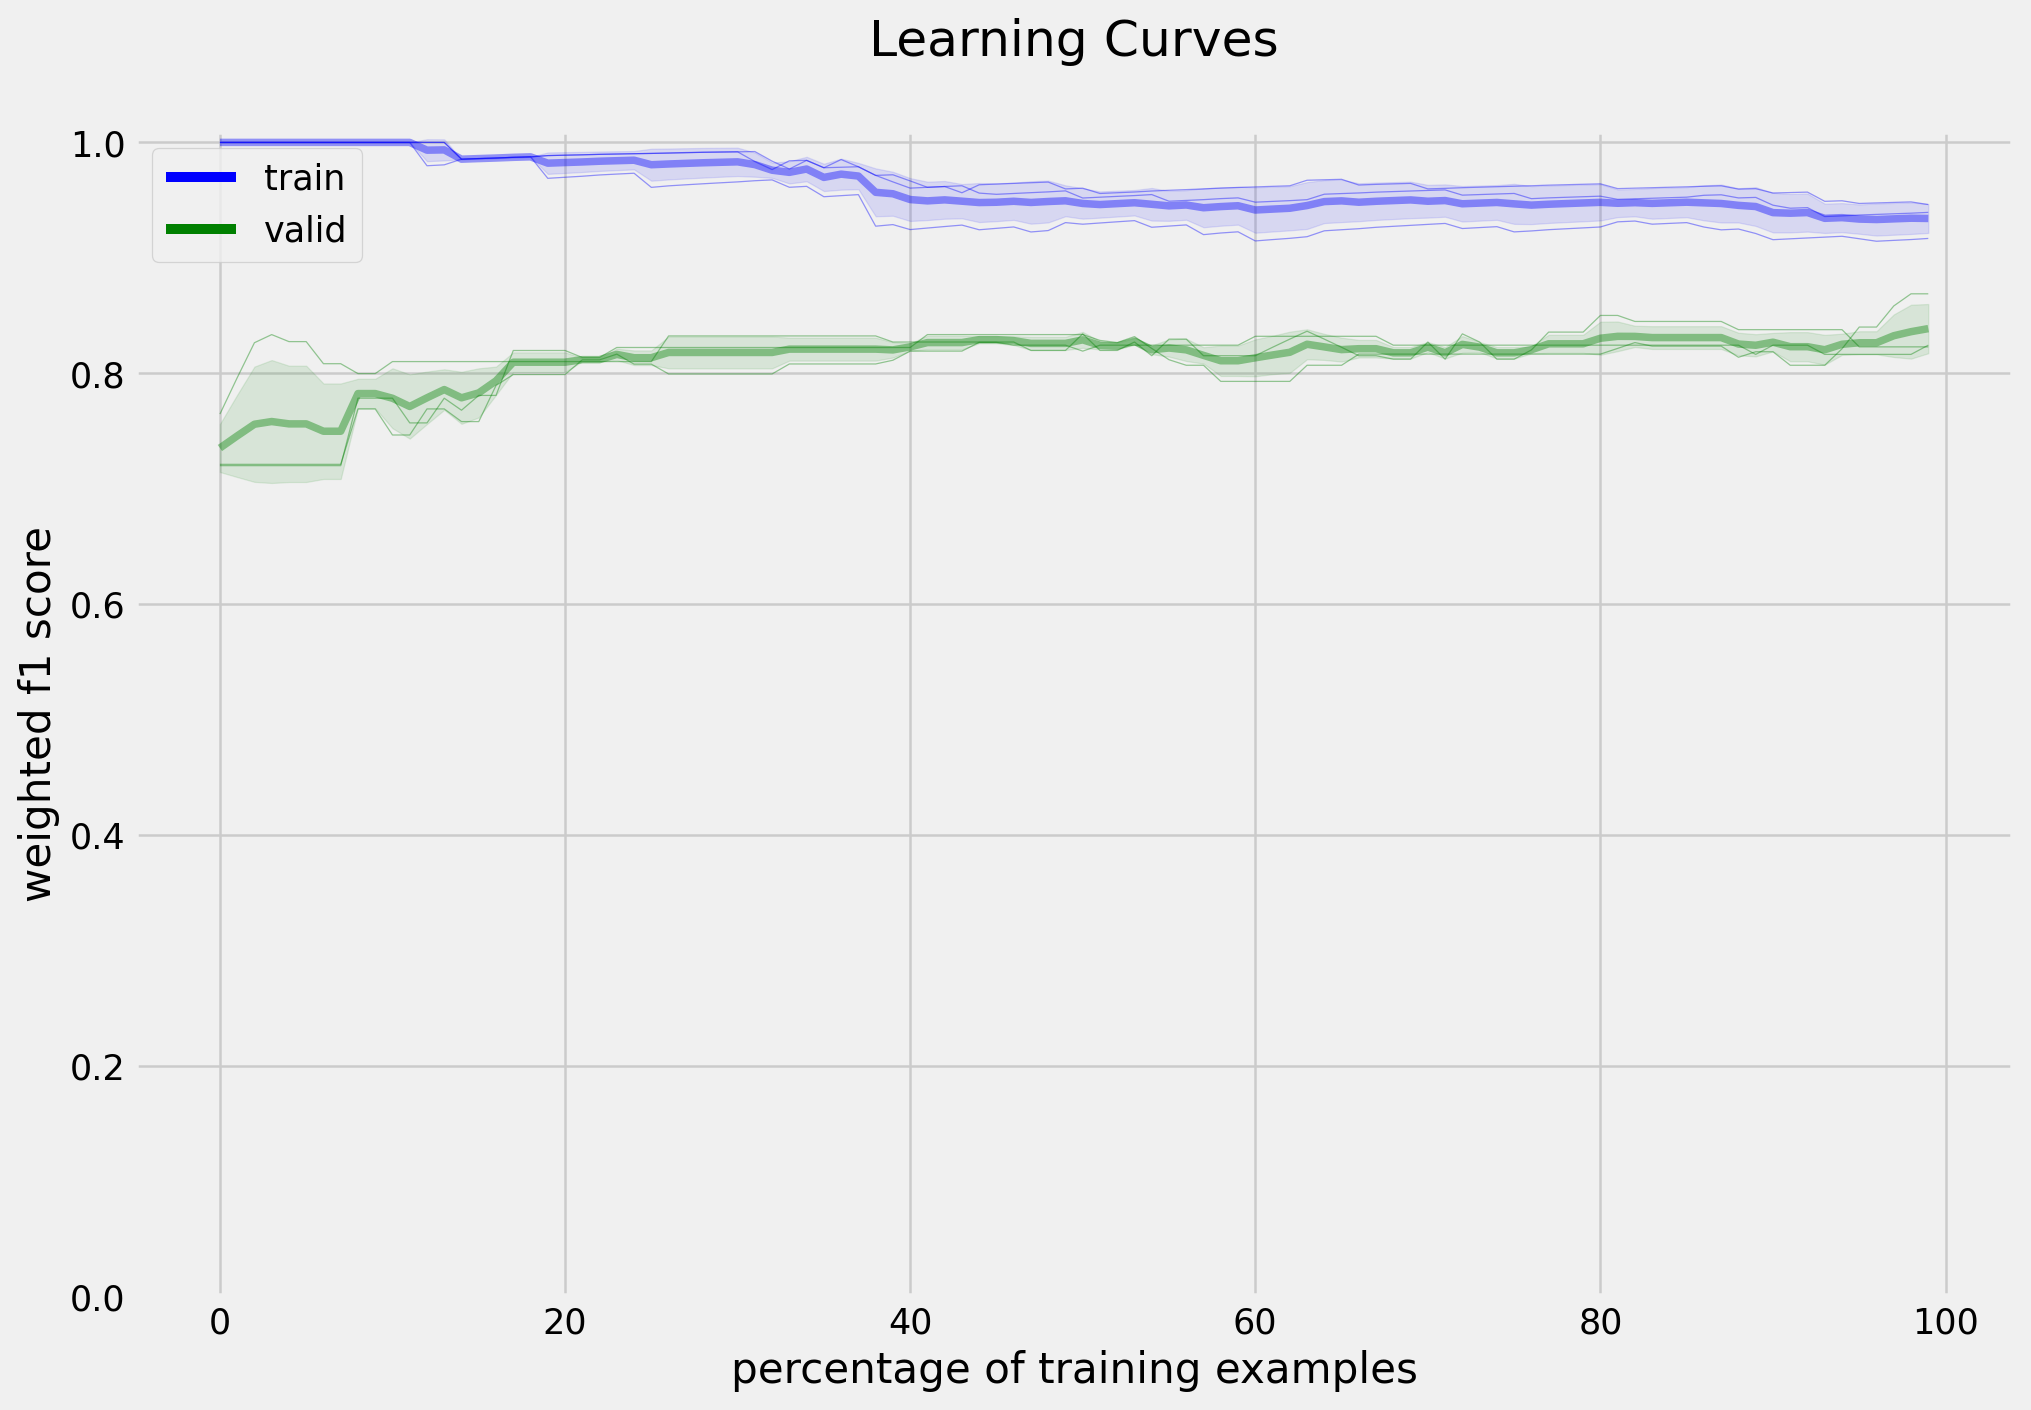

In [25]:
plot_learning_curves(lc_res)

In [26]:
imp_function = get_feature_importances(model)

In [27]:
(imp_function[(imp_function.label=='engineer')
              &(imp_function.feature=='tfidf_minimum_qual')]
 .sort_values('importance', ascending=False).head())

,feature,term,importance,label
328107,tfidf_minimum_qual,software development,0.946863,engineer
328108,tfidf_minimum_qual,bachelor degree,0.927037,engineer
328109,tfidf_minimum_qual,practical experience,0.920354,engineer
328111,tfidf_minimum_qual,equivalent practical experience,0.914002,engineer
328110,tfidf_minimum_qual,equivalent practical,0.914002,engineer


In [28]:
(imp_function[(imp_function.label=='architect')
              &(imp_function.feature=='tfidf_minimum_qual')]
 .sort_values('importance', ascending=False).head())

,feature,term,importance,label
1,tfidf_minimum_qual,cloud computing,0.889566,architect
2,tfidf_minimum_qual,experience cloud,0.697095,architect
4,tfidf_minimum_qual,experience customer,0.618317,architect
5,tfidf_minimum_qual,experience customer facing,0.618317,architect
6,tfidf_minimum_qual,experience customer facing role,0.618317,architect


## Model On Location

In [29]:
min_n_ads_location = 20

conditions = (
    (ads.function=='engineer')
    & (ads.location.isin(location_counts[location_counts>=min_n_ads_location].index.to_list()))
    & (ads.location != 'unknown')
)

to_model = ads[conditions].copy()

In [30]:
label_enc = LabelEncoder()
to_model['location_enc'] = label_enc.fit_transform(to_model.location.astype('str'))

In [31]:
to_model.location.value_counts()

Mountain View       66
Sunnyvale           34
Bengaluru           31
Xindian District    22
Warsaw              16
Atlanta             13
Name: location, dtype: int64

In [32]:
X = to_model.drop('location_enc', axis=1)
y = to_model.location_enc

In [33]:
model = multi_col_pipe.fit(X, y)

In [34]:
print_scores(model, X, y, cv=5)

Running 5 cross validation folds...
------------------------------------------------------------------------------------------------------------------------
fit_time, mean: 0.38, std: 0.02
score_time, mean: 0.06, std: 0.00
test_score, mean: 0.46, std: 0.06
train_score, mean: 0.87, std: 0.01


In [35]:
steps = 100

lc_res = learning_curve(model, X, y, cv=3, train_sizes=np.linspace(0.1, 1.0, steps), scoring='f1_weighted', n_jobs=6, random_state=42)

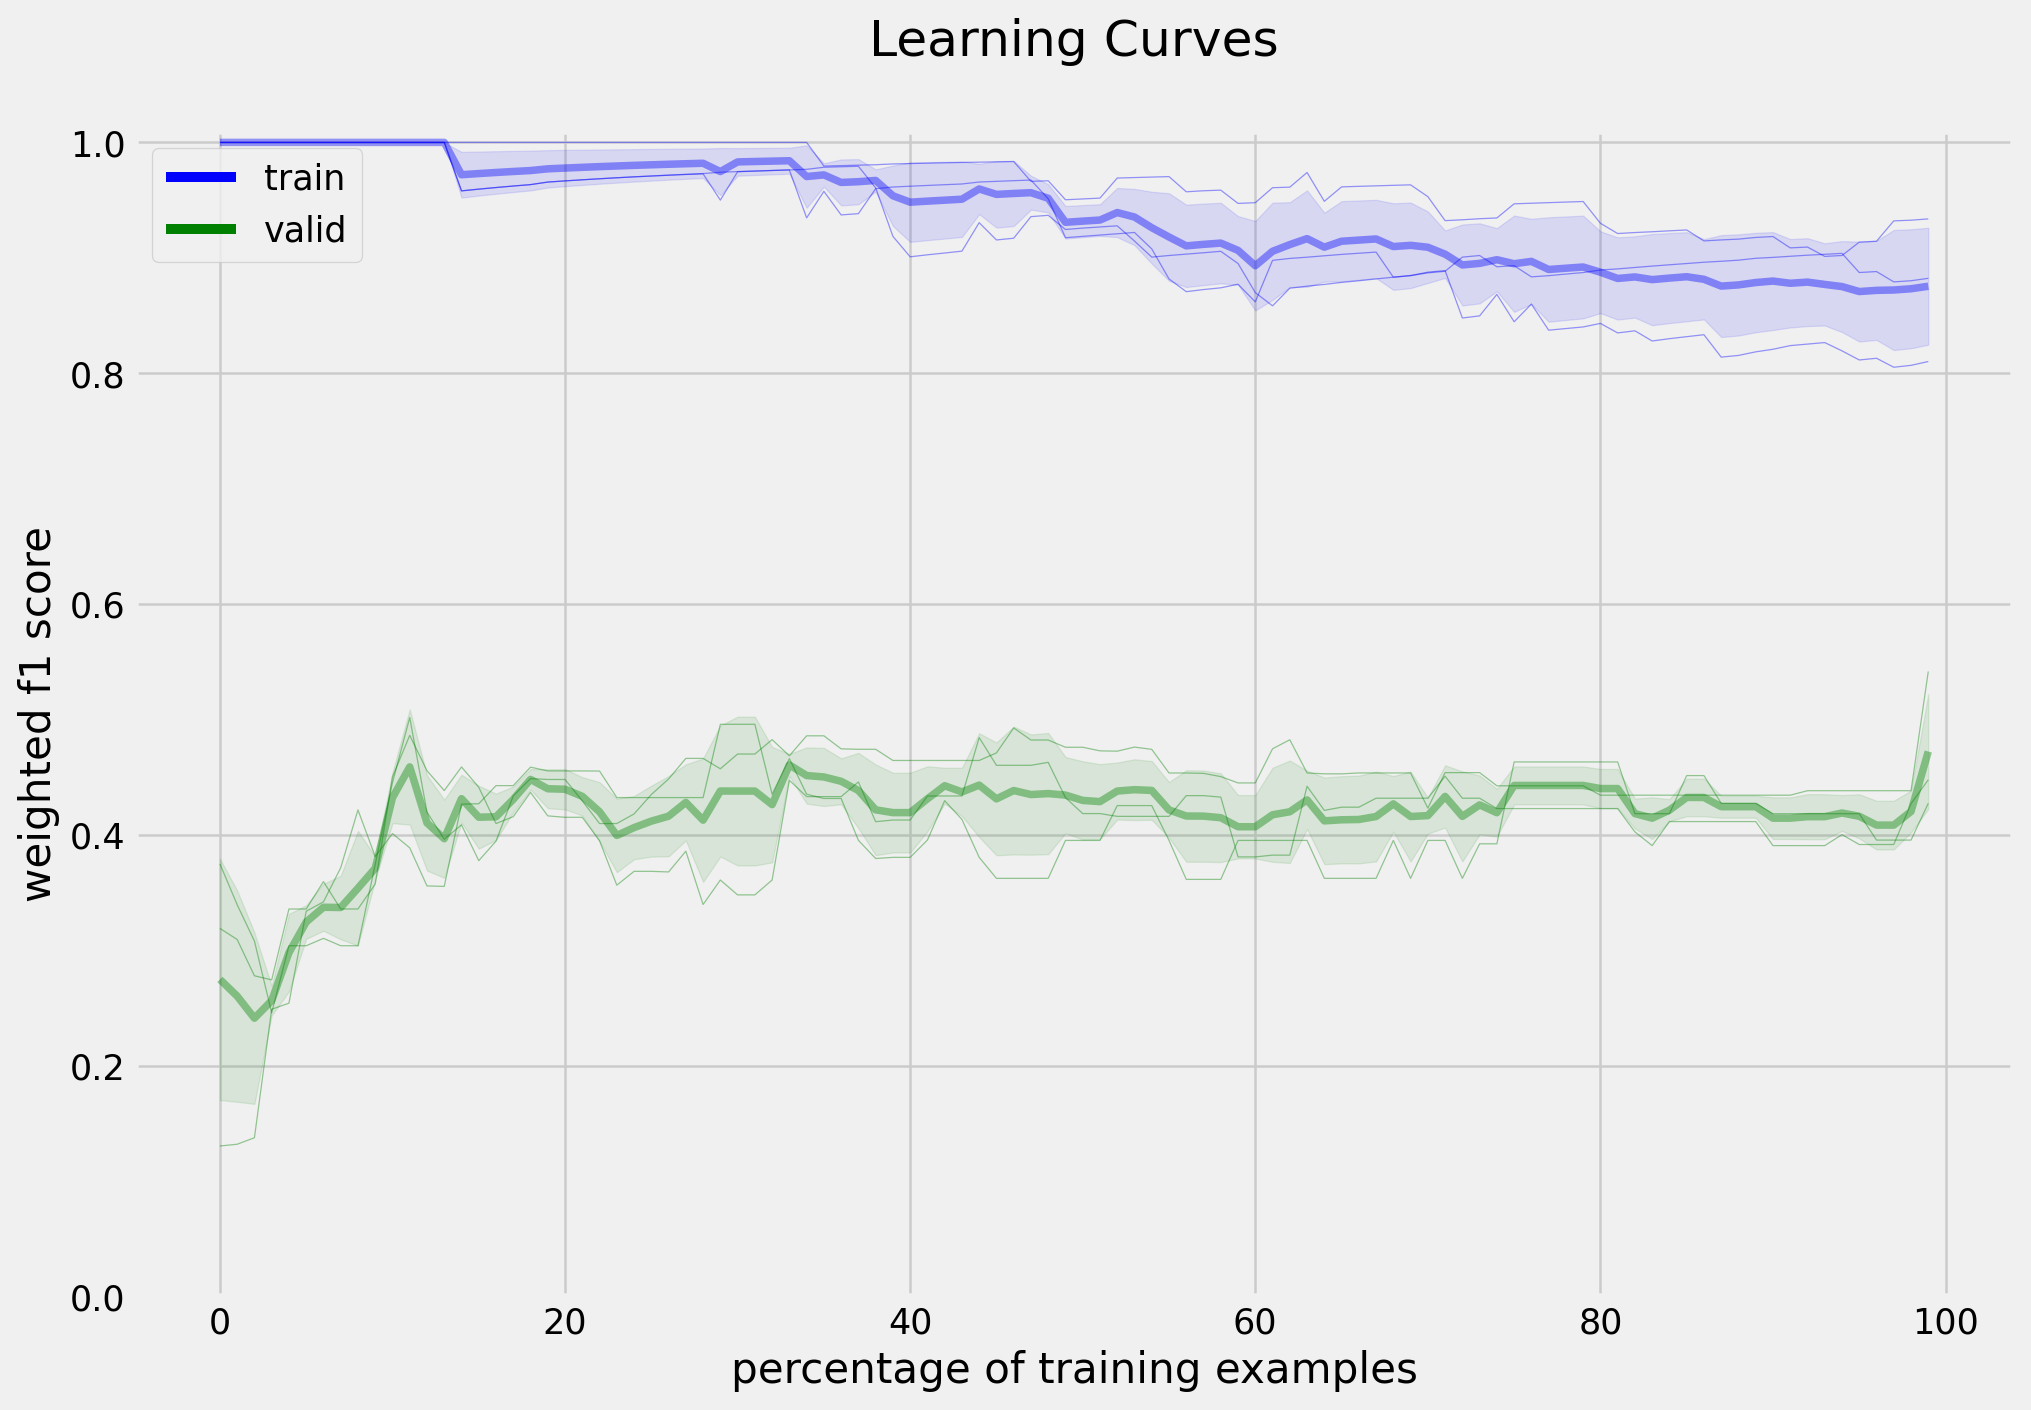

In [36]:
plot_learning_curves(lc_res)

In [37]:
imp_location = get_feature_importances(model)

In [38]:
(imp_location[(imp_location.label=='Mountain View')
              &(imp_location.feature=='tfidf_minimum_qual')]
 .sort_values('importance', ascending=False).head())

,feature,term,importance,label
156650,tfidf_minimum_qual,development experience,1.000000,Mountain View
156651,tfidf_minimum_qual,software development experience,0.941142,Mountain View
156652,tfidf_minimum_qual,software development,0.936391,Mountain View
156653,tfidf_minimum_qual,experience years,0.903056,Mountain View
156654,tfidf_minimum_qual,advanced degree,0.865089,Mountain View


In [39]:
(imp_location[(imp_location.label=='Bengaluru')
              &(imp_location.feature=='tfidf_minimum_qual')]
 .sort_values('importance', ascending=False).head())

,feature,term,importance,label
78326,tfidf_minimum_qual,java python,0.897739,Bengaluru
78327,tfidf_minimum_qual,computer science,0.761015,Bengaluru
78328,tfidf_minimum_qual,bachelor degree computer science,0.731944,Bengaluru
78329,tfidf_minimum_qual,bachelor degree computer,0.731944,Bengaluru
78331,tfidf_minimum_qual,experience experience,0.730475,Bengaluru


## Model On Seniority

In [40]:
min_n_ads_seniority = 40

conditions = (
    (ads.function=='engineer')
    & (ads.seniority.isin(seniority_counts[seniority_counts>=min_n_ads_seniority].index.to_list()))
    & (ads.seniority != 'unknown')
)

to_model = ads[conditions].copy()

In [41]:
to_model.seniority.value_counts()

l3-l4     286
staff      59
senior     41
Name: seniority, dtype: int64

In [42]:
label_enc = LabelEncoder()
to_model['seniority_enc'] = label_enc.fit_transform(to_model.seniority.astype('str'))

In [43]:
X = to_model.drop('seniority_enc', axis=1)
y = to_model.seniority_enc

In [44]:
model = multi_col_pipe.fit(X, y)

In [45]:
print_scores(model, X, y, cv=5)

Running 5 cross validation folds...
------------------------------------------------------------------------------------------------------------------------
fit_time, mean: 0.63, std: 0.01
score_time, mean: 0.10, std: 0.01
test_score, mean: 0.79, std: 0.03
train_score, mean: 0.93, std: 0.01


In [46]:
steps = 100

lc_res = learning_curve(model, X, y, cv=3, train_sizes=np.linspace(0.1, 1.0, steps), scoring='f1_weighted', n_jobs=6, random_state=42)

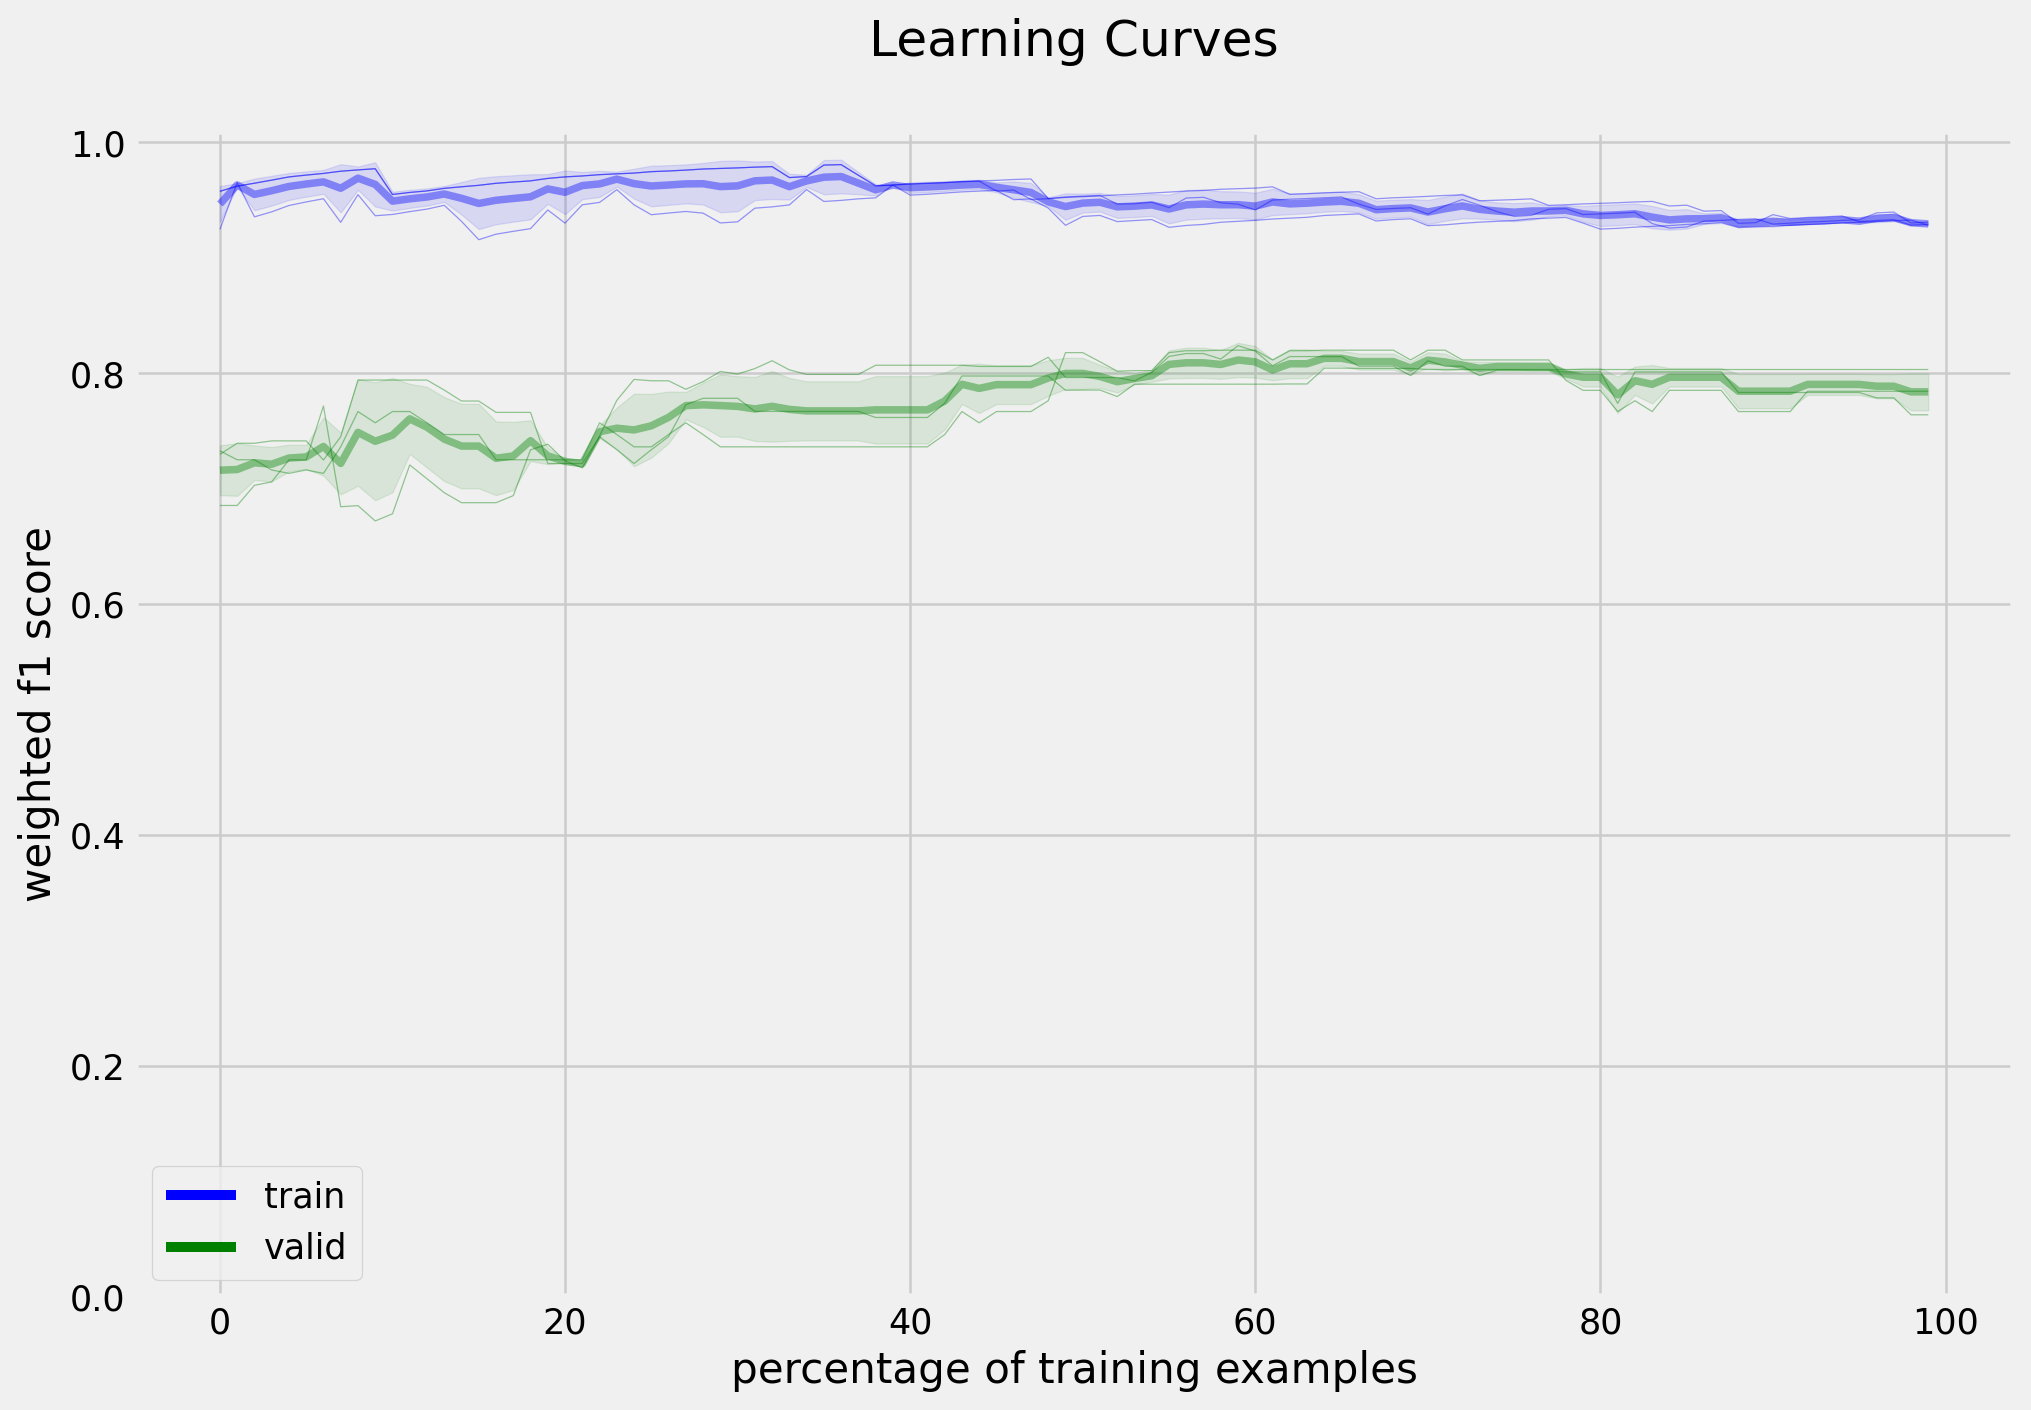

In [47]:
plot_learning_curves(lc_res)

In [48]:
imp_seniority = get_feature_importances(model)

In [49]:
(imp_seniority[(imp_seniority.label=='l3-l4')
              &(imp_seniority.feature=='tfidf_minimum_qual')]
 .sort_values('importance', ascending=False).head())

,feature,term,importance,label
1,tfidf_minimum_qual,computer science,0.871627,l3-l4
3,tfidf_minimum_qual,degree computer,0.846423,l3-l4
2,tfidf_minimum_qual,degree computer science,0.846423,l3-l4
4,tfidf_minimum_qual,practical experience,0.841875,l3-l4
6,tfidf_minimum_qual,bachelor degree computer science,0.840822,l3-l4


In [50]:
(imp_seniority[(imp_seniority.label=='senior')
              &(imp_seniority.feature=='tfidf_minimum_qual')]
 .sort_values('importance', ascending=False).head())

,feature,term,importance,label
124864,tfidf_minimum_qual,experience years,1.000000,senior
124865,tfidf_minimum_qual,degree equivalent practical experience years,0.948622,senior
124866,tfidf_minimum_qual,development experience,0.934721,senior
124867,tfidf_minimum_qual,software development,0.897823,senior
124868,tfidf_minimum_qual,software development experience,0.879124,senior


In [51]:
(imp_seniority[(imp_seniority.label=='staff')
              &(imp_seniority.feature=='tfidf_minimum_qual')]
 .sort_values('importance', ascending=False).head())

,feature,term,importance,label
249728,tfidf_minimum_qual,software development,1.000000,staff
249729,tfidf_minimum_qual,software development experience,0.963945,staff
249730,tfidf_minimum_qual,development experience,0.948301,staff
249731,tfidf_minimum_qual,10 years,0.912179,staff
249732,tfidf_minimum_qual,experience 10 years,0.879484,staff
